# Counting Bloom Filter (CBF)

In [ ]:
import random 
import string 
import matplotlib.pyplot as plt
import numpy as np
import math
from requests import get
import time

In [ ]:
class CountingBloomFilter:
    """
    Implements the Counting Bloom Filter which supports insertion, deletion, and search
    """
    def __init__(self, num_items=100000, fpr=0.01, num_hashfn=None):
        """
        Initializes the Counting Bloom Filter.

        Parameters
        ----------
        num_items : int
            Number of items to store in the filter. Default is 100000.
        fpr : float
            False positive rate of the filter. Default is 0.01.
        num_hashfn : int or boolean
            Number of hash functions to use. If not specified, the optimal
            number of hash functions is calculated based on the memory size
            and number of items.

        Attributes
        ----------
        num_items : int
            Number of items to store in the filter.
        fpr : float
            False positive rate of the filter.
        memory_size : int
            Number of cells in the Counting Bloom Filter.
        bit_array : numpy.ndarray
            Array of integers representing the Counting Bloom Filter.
        num_hashfn : int
            Number of hash functions used by the filter.
        hash_seeds : numpy.ndarray
            Array of random hash seeds used by the filter.
        """
        self.num_items = num_items
        self.fpr = fpr

        # Calculate the memory size based on the number of items and the false positive rate
        self.memory_size = int(self.num_items * (-1.44 * np.log2(self.fpr)))
        
        # Initialize the bit array with zeros
        self.bit_array = np.zeros(self.memory_size, dtype=np.int32)

        # Calculate the optimal number of hash functions based on memory size and number of items
        if num_hashfn is None:
            self.num_hashfn = int((self.memory_size / self.num_items) * math.log(2))
        else:
            self.num_hashfn = num_hashfn

        # Generate random hash seeds for the number of hash functions
        self.hash_seeds = np.random.randint(0, np.iinfo(np.int32).max, size=self.num_hashfn, dtype=np.int32)

    def hash_cbf(self, item):
        """
        Returns hash values of an item.

        Parameters
        ----------
        item : str
            Item to hash.

        Returns
        -------
        list of int
            Hash values of the item.
        """
        hash_values=[]
        # Use different integers p for different hash functions
        for seed in self.hash_seeds:
            hash_value = 0
            p_pow=1
            p=seed
            for char in item:
                # Calculate the hash value of each character using polynomial rolling hash function
                hash_value = (hash_value + (ord(char) - ord('a') + 1) * p_pow) % self.memory_size
                p_pow = (p_pow * p) % self.memory_size
            hash_values.append(hash_value)
            
        return hash_values

    def search(self, item):
        """
        Queries the membership of an element.

        Parameters
        ----------
        item : str
            Item to search for.

        Returns
        -------
        bool
            True if the item is probably in the filter, False otherwise.
        """
        hash_values = self.hash_cbf(item)
        # If at least one corresponding position in CBF array is 0 - the element is definitely not in CBF
        # Otherwise, it probably is
        for hash_value in hash_values:
            if self.bit_array[hash_value] == 0:
                return False
        return True

    def insert(self, item):
        """
        Inserts a string to the filter.

        Parameters
        ----------
        item : str
            Item to search for.
        """
        hash_values = self.hash_cbf(item)
        # Increment the corresponding position in the CBF array by one
        for hash_value in hash_values:
            self.bit_array[hash_value] += 1

    def delete(self, item):
        """
        Removes a string from the filter.

        Parameters
        ----------
        item : str
            Item to search for.
        """
        if not self.search(item):
            print("Item not in filter.")
        hash_values = self.hash_cbf(item)
        # Decrement the corresponding position in the CBF array by one if the element is considered to be present in CBF
        for hash_value in hash_values:
            if self.bit_array[hash_value] > 0:
                self.bit_array[hash_value] -= 1
            else:
                print("Item not in filter.")

# Test Cases

In [ ]:
# Create a tiny CBF
cbf = CountingBloomFilter()

# check if it is deterninistic - hashing the same string shoudl always produce the same output
assert(cbf.hash_cbf("qwerty1") == cbf.hash_cbf("qwerty1"))
assert(cbf.hash_cbf("ytrewq1") == cbf.hash_cbf("ytrewq1"))

# check if it produces unique values for different strings
assert(cbf.hash_cbf("qwerty1") != cbf.hash_cbf("ytrewq1"))

# check numbers and symbols
assert(cbf.hash_cbf("567") != cbf.hash_cbf("-567"))
assert(cbf.hash_cbf("@@!!") == cbf.hash_cbf("@@!!"))

print("All test cases passed!")

All test cases passed!


# Hash Function Test

No collisions found


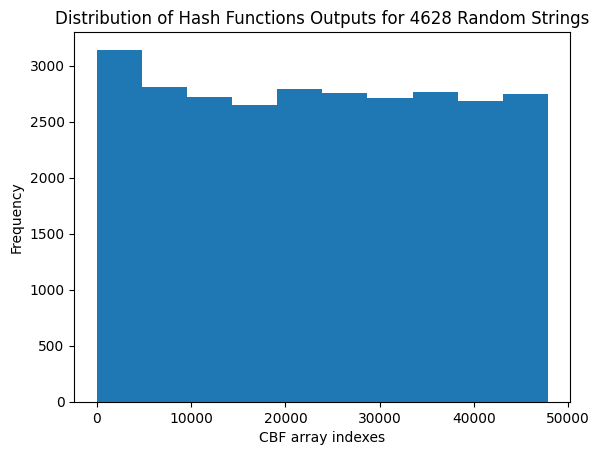

In [ ]:
def min_collisions(num_items):
    """
    Creates a Counting Bloom Filter and adds random strings to it. Calculates the percentage of collisions
    found and plots the distribution of the hash functions' outputs.

    Parameters
    ----------
    num_items: int
        The number of items to add to the filter.
    """
    hash_set = []
    num_collisions = 0
    cbf = CountingBloomFilter(num_items=num_items)
    index_list = []
    string_list = []

    # generate random strings and add them to the filter
    for i in range(num_items):
        s = "".join(random.choices(string.ascii_lowercase, k=random.randint(1,15)))
        string_list.append(s)

    # check for collisions and record their hash values
    for s in set(string_list):
        h = cbf.hash_cbf(s)
        if h in hash_set:
            num_collisions += 1
        for i in h:
            index_list.append(i)
        hash_set.append(h)

    # print percentage of collisions found and plot distribution of hash function outputs
    if num_collisions > 0:
        print("Percentage of collisions found:", (num_collisions / num_items) * 100)
    else:
        print("No collisions found")

    plt.hist(index_list)
    plt.title(f'Distribution of Hash Functions Outputs for {len(set(string_list))} Random Strings')
    plt.xlabel('CBF array indexes')
    plt.ylabel('Frequency')

min_collisions(5000)

# Computational Analyses

In [ ]:
url_version_1 = 'https://bit.ly/39MurYb'
url_version_2 = 'https://bit.ly/3we1QCp'
url_version_3 = 'https://bit.ly/3vUecRn'


def get_txt_into_list_of_words(url):
    '''
    Cleans the text data.

    Parameters
    ----------
    url : string
        The URL for the txt file.

    Returns
    -------
    data_just_words_lower_case: list
        List of "cleaned-up" words sorted by the order they appear in the original file.

    '''

    # Define a list of characters that we want to remove from the text
    bad_chars = [';', ',', '.', '?', '!', '_', '[', ']', '(', ')', '*']
    
    # Get the text data from the URL
    data = get(url).text
    
    # Remove the unwanted characters from the text
    data = ''.join(c for c in data if c not in bad_chars)
    
    # Replace newlines, tabs, and carriage returns with spaces
    data_without_newlines = ''.join(
        c if (c not in ['\n', '\r', '\t']) else " " for c in data)
    
    # Split the text into a list of words
    data_just_words = [
        word for word in data_without_newlines.split(" ") if word != ""]
    
    # Convert all words to lowercase
    data_just_words_lower_case = [word.lower() for word in data_just_words]
    
    # Return the cleaned-up list of words
    return data_just_words_lower_case



version_1 = get_txt_into_list_of_words(url_version_1)
version_2 = get_txt_into_list_of_words(url_version_2)
version_3 = get_txt_into_list_of_words(url_version_3)

**Memory Size vs. FPR**

Version 1 Data


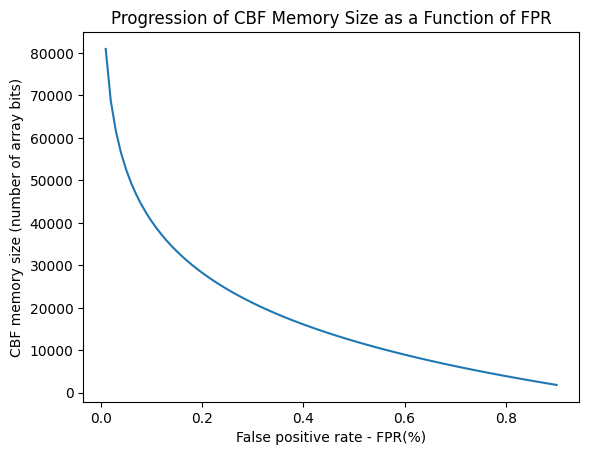

Version 2 Data


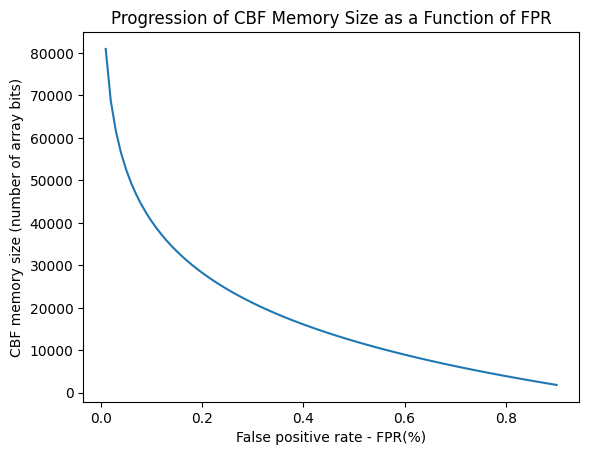

Version 3 Data


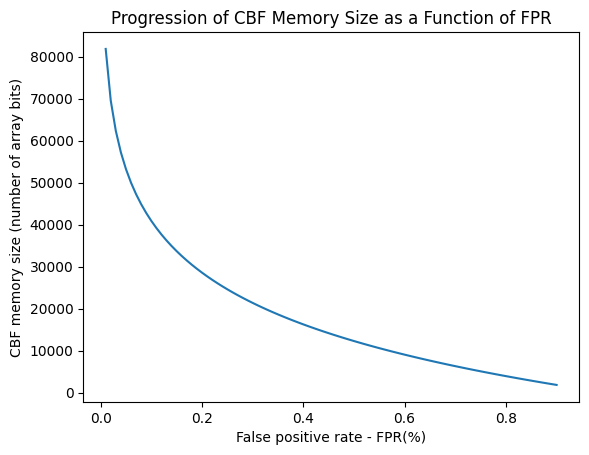

In [ ]:
def memory_size_vs_fpr(data):
    """
    Plot the progression of CBF memory size as a function of false positive rate.

    Parameters
    ----------
    data : list
        The data to be used for testing the Counting Bloom Filter.
    """
    memory_sizes = []
    fpr = np.arange(0.01, 0.91, 0.01)

    # For each FPR, create a CBF and record its memory size
    for i in fpr:
        cbf = CountingBloomFilter(num_items=len(data), fpr=i)
        memory_sizes.append(cbf.memory_size)

    # Plot the memory size vs. FPR
    plt.plot(fpr, memory_sizes)
    plt.title('Progression of CBF Memory Size as a Function of FPR')
    plt.xlabel('False positive rate - FPR(%)')
    plt.ylabel('CBF memory size (number of array bits)')
    plt.show()
    

# Use all versions for testing
print('Version 1 Data')
memory_size_vs_fpr(version_1) 
print('Version 2 Data')
memory_size_vs_fpr(version_2) 
print('Version 3 Data')
memory_size_vs_fpr(version_3) 

**Memory Size vs. Number of Items**

Version 1 Data


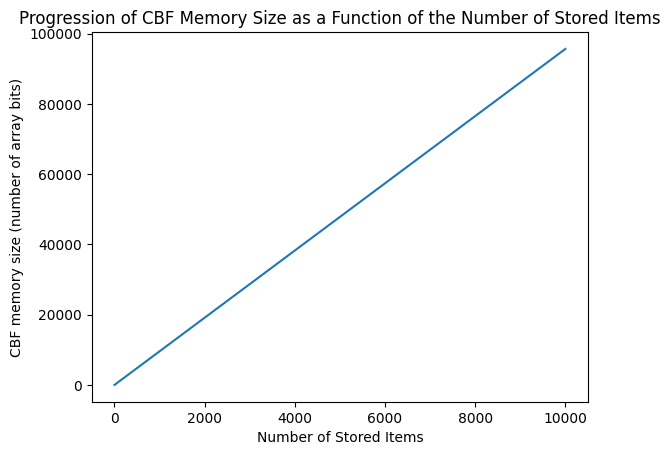

Version 2 Data


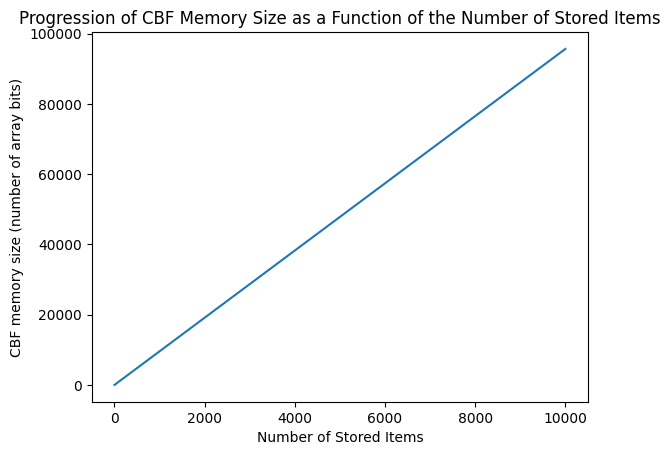

Version 3 Data


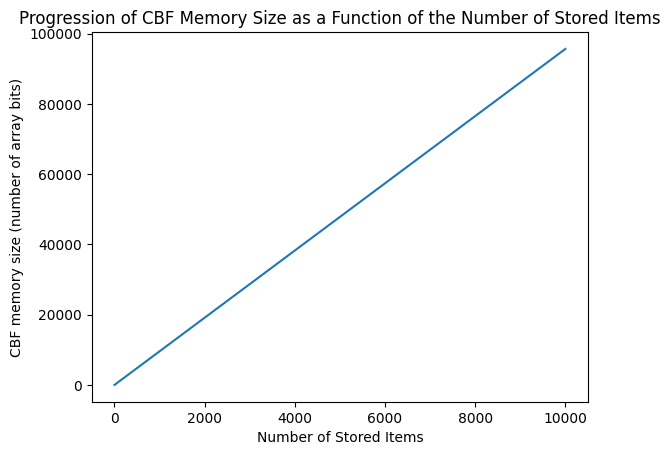

In [ ]:
def memory_size_vs_num_items(data):
    """
    Plot the progression of CBF memory size as a function of the number of items.

    Parameters
    ----------
    data : list
        The data to be used for testing the Counting Bloom Filter.
    """

    memory_sizes = []
    num_items = np.arange(1,10002,50)

    # For each number of items, create a CBF and record its memory size
    for i in num_items:
        cbf=CountingBloomFilter(num_items=i)
        memory_sizes.append(cbf.memory_size)

    # Plot the memory size vs. number of items
    plt.plot(num_items,memory_sizes)
    plt.title('Progression of CBF Memory Size as a Function of the Number of Stored Items')
    plt.xlabel('Number of Stored Items')
    plt.ylabel('CBF memory size (number of array bits)')
    plt.show()

    

# Use all versions for testing
print('Version 1 Data')
memory_size_vs_num_items(version_1) 
print('Version 2 Data')
memory_size_vs_num_items(version_2) 
print('Version 3 Data')
memory_size_vs_num_items(version_3) 

**FPR vs. Number of Hash Function**

Version 1 Data


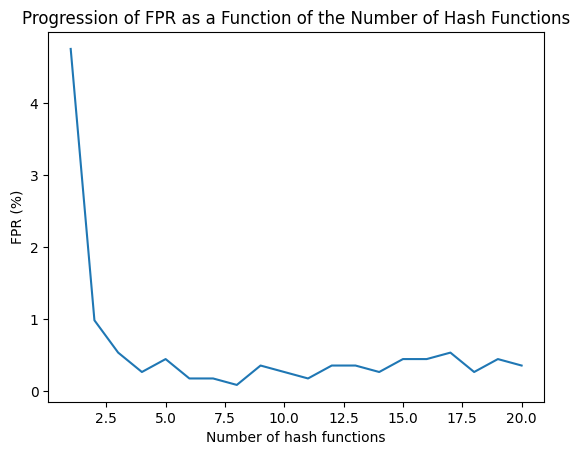

Version 2 Data


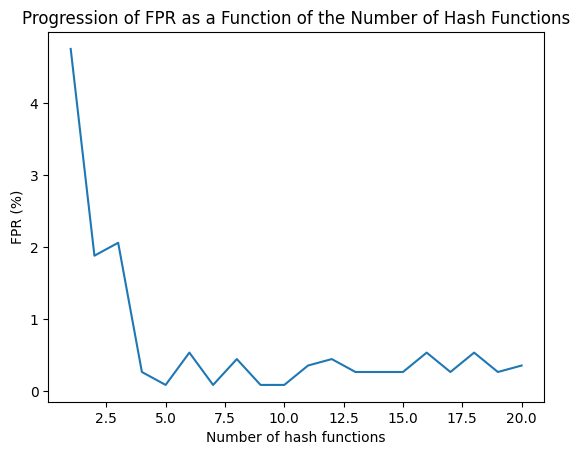

Version 3 Data


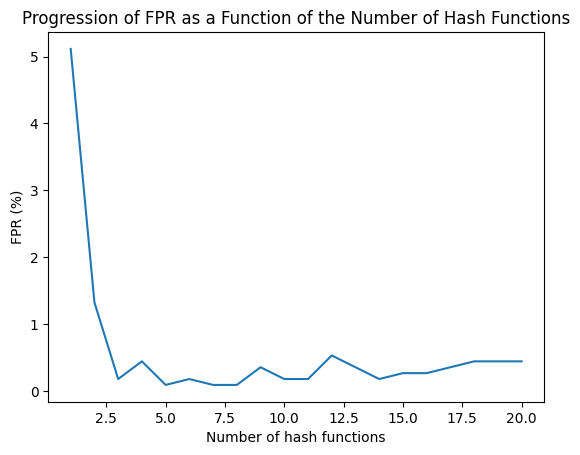

In [ ]:
def fpr_vs_num_hashfn(data):
    """
    Plot the progression of FPR as a function of the number of hash functions.

    Parameters
    ----------
    data : list
        The data to be used for testing the Counting Bloom Filter.
    """

    fpr_list = []
    num_hashfn = np.arange(1,21,1)
    # Extract unique words
    data=list(set(data))

    for i in num_hashfn:
        fpr=0
        cbf=CountingBloomFilter(num_items=len(data),num_hashfn=i)

        # Insert half of input data into the CBF
        for word in data[:len(data)//2]:
            cbf.insert(word)

        # Check of words from the other half of the data are in the CBF
        for word in data[len(data)//2:]:
            if cbf.search(word)==True:
                fpr+=1

        # Find FPR as a percentage of falsely classified words
        fpr_list.append((fpr/len(data[:len(data)//2]))*100)
        
    # Plot the FPR vs. number of hash functions
    plt.plot(num_hashfn,fpr_list)
    plt.title('Progression of FPR as a Function of the Number of Hash Functions')
    plt.xlabel('Number of hash functions')
    plt.ylabel('FPR (%)')
    plt.show()

    

# Use Version 1 for testing
print('Version 1 Data')
fpr_vs_num_hashfn(version_1) 
print('Version 2 Data')
fpr_vs_num_hashfn(version_2) 
print('Version 3 Data')
fpr_vs_num_hashfn(version_3) 

**Access Time vs. Number of Items**

Version 1 Data


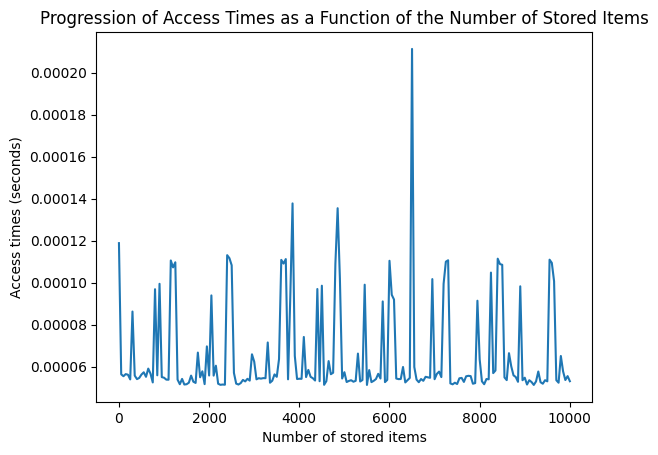

Version 2 Data


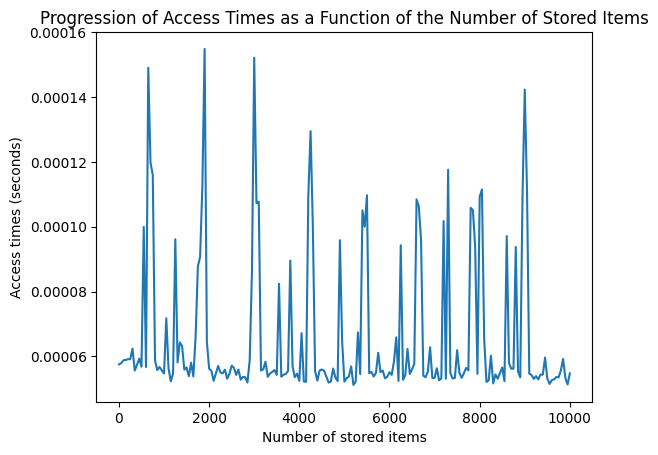

Version 3 Data


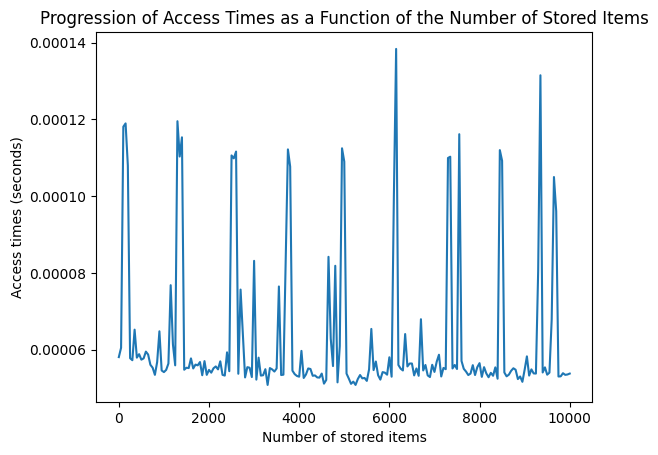

In [ ]:
def acc_time_vs_num_items(data):
    """
    Plot the progression of access time as a function of the number of items

    Parameters
    ----------
    data : list
        The data to be used for testing the Counting Bloom Filter.
    """

    acc_times = []
    num_items = np.arange(1,10002,50)
    # Choose a set of random words that I believe are definitely in the text
    search_words=['the','Shakespear','love','and','tomorrow']

    for i in num_items:
        cbf=CountingBloomFilter(num_items=i)
        times=[]

        # Insert all words in the CBF
        for word in data:
            cbf.insert(word)

        # Search for selected words in the CBF and record time
        for word in search_words:
            start=time.time()
            cbf.search(word)
            end=time.time()
            times.append(end-start)
        
        acc_times.append(np.mean(times))

    # Plot the access time vs. number of items
    plt.plot(num_items,acc_times)
    plt.title('Progression of Access Times as a Function of the Number of Stored Items')
    plt.xlabel('Number of stored items')
    plt.ylabel('Access times (seconds)')
    plt.show()

    

# Use Version 1 for testing
print('Version 1 Data')
acc_time_vs_num_items(version_1) 
print('Version 2 Data')
acc_time_vs_num_items(version_2) 
print('Version 3 Data')
acc_time_vs_num_items(version_3) 

# **Plagiarism Detector Applicaton**

**CBFs and Hashing**

In [ ]:
class PlagiarismDetector:
    """
    A class to detect plagiarism between two texts using Counting Bloom Filters.
    """
    def __init__(self, num_items=10000, fpr=0.01, num_hashfn=None, n=10):
        """
        Initializes the PlagiarismDetector.

        Parameters:
        -----------
        num_items : int
            Number of cells in the Counting Bloom Filter.
        fpr : float
            Desired false positive rate of the Counting Bloom Filter.
        num_hashfn : int, optional
            Number of hash functions to use in the Counting Bloom Filter.
        n : int
            Size of n-grams to use in the plagiarism detection.

        Attributes:
        -----------
        cbf : CountingBloomFilter
            The Counting Bloom Filter used for plagiarism detection.
        n : int
            The size of n-grams used in plagiarism detection.
        """
        self.cbf = CountingBloomFilter(num_items=num_items, fpr=fpr, num_hashfn=num_hashfn)
        self.n = n

    def preprocess(self, text):
        """
        Preprocesses the text by converting it to lowercase and splitting it into n-grams.

        Parameters:
        -----------
        text : str
            Text to preprocess.

        Returns:
        --------
        ngrams : list of str
            Preprocessed n-grams.
        """
        # Devide the text into n-grams
        ngrams = [''.join(text[i:i+self.n]) for i in range(len(text)-self.n+1)]
        return ngrams

    def add_to_cbf(self,ngrams):
        """
        Adds n-grams to the Counting Bloom Filter.

        Parameters:
        -----------
        ngrams : list of str
            N-grams to add to the Counting Bloom Filter.
        """
        for i in ngrams:
            self.cbf.insert(i)

    def detect_plagiarism(self, text1, text2):
        """
        Detects the extent of plagiarism between two texts as a percentage of common phrases.

        Parameters:
        -----------
        text1 : list of str
            First text to compare.
        text2 : list of str
            Second text to compare.

        Returns:
        --------
        result : list of float and list of str
            The percentage of n-grams in text1 that are also in text2 and the list of common phrases between the two texts.
        """
        intersection=0
        common_phrases=[]
        # Divide into n-grams and add to CBF
        ngrams1 = self.preprocess(text1)
        ngrams2 = self.preprocess(text2)
        self.add_to_cbf(ngrams1)
        # Count common n-grams between texts based on CBF presense and return corresponding percentage
        for i in ngrams2:
            if self.cbf.search(i):
                intersection+=1
                common_phrases.append(i)
        return [intersection / len(ngrams1) * 100 if len(ngrams1) > 0 else 0.0, common_phrases]

*Version 1 vs. Version 2*

In [ ]:
def plag_detector_result(text1, text2):
    """
    Prints the result of plagiarism detection between two texts.

    Parameters:
    -----------
    text1 : list of str
        First text to compare.
    text2 : list of str
        Second text to compare.
    """
    # Create an instance of a plagiarism detector and use it, printing the results
    detector = PlagiarismDetector()
    plagiarism_percentage = detector.detect_plagiarism(text1, text2)
    print(f"Plagiarism percentage: {plagiarism_percentage[0]:.2f}%")
    print(f"Common Phrases: {plagiarism_percentage[1]}")

plag_detector_result(version_1, version_2)

Plagiarism percentage: 0.45%
Common Phrases: ['arehisderive1990-1993becomfortalternativelypersonalformthe', 'ispridethatwatchnoreachamnewtriflesi', 'acceptablecivilfromallpicturewithtolackingfarthestwinds', 'mostsky:entertainreplacementhungryfacetonguethyslavemy', 'areinendahourwithwearywhenthatclearer', "theirsolenewtheirthoubeauty'sandetextthymutual", "dothwithbeauty'sarethouofiscopemehis", 'daysmythroughtractnothinethenshouldsomestring', 'heartthereyouofandscarcelythereadandand', "formtoosoeye'sonehisgoodwitperson", 'asthemnoyouthiseyecouldofhimthee', 'bydothemyunfairtosmotherindirectlyshowdisplays', "beguiledthoughanmadeofthatandlove'ssocan", 'leisureheavendisdainscanthysunkformethousuch', 'convert:approveetextcantoalthoughyouigonepurpose', 'desireoutcollegefollylibrarythepaintedagefreeof', 'worththylimitationagainstthatdreamssurvivethisfitnessdo', 'is43knowledgesheparticularselfandgosecondlove', 'deaththyandofyoutoitway:thoughtevery', 'helpthattomyprovokehandfreshtotoa', 'tothouyo

*Version 2 vs. Version 3*

In [ ]:
plag_detector_result(version_2, version_3)

Plagiarism percentage: 0.50%
Common Phrases: ['igladguiltpraisinglovingfaultsthethateyebareness', 'wherenoletthemycomingseparationassuredtorazed', 'yourtowithtimesthouandsweetreplacementiwarranty', 'exactlearnwith4pearl13thatmykeepissueless', 'daythouthe7mefairwhichboththytheir', 'digbarsawilliamthoughatheethounothingetext', 'bidseternalthouwilliampartaofthythebefore', "heavilyimindstrangelytoashowhe'sbestis", 'i1990-1993tellthyyourofanthenlegalher', 'eyeshouldrootissotomediumlikefindthee', 'giveandeyewithsomedecaypawsmyperfectiondwell', 'broodbeautysuchontheplaintofleshotherscouplement', 'heaveninetextshowsagainstevenprintthysucceedingif', 'fromsurmountthoughtsprofitlessmuchtobutlikewhichwhere:', 'whichbeforinjuriousdivideyouleavetimefora', 'thatdistributedifwetandrainour10onealternatively', 'isinsisbeautybootlessthanwhenhowbymen', 'youtheofandthytherecordearththathearsay', "inthinkmenabuseaughthidbraveprojectdeath'sthat", "intomesuff'ringascontrollingintendedsubjectnotperson", "hatht

*Version 1 vs. Version 3*

In [ ]:
plag_detector_result(version_1, version_3)

Plagiarism percentage: 0.58%
Common Phrases: ['ofthemyanywidowasunrespectedrudeandantique', 'thouandsweetreplacementiwarrantyareartflowerscdroms', 'thatofwwwgutenbergorgshadeinthatthoughsoisthy', "therethenrightsonebutbymother'sthythethis", 'lessthineproprietarythywhenanyonewasbethein', 'hishaththeeoftenofvassalagecuttimebeimplications', 'tothethisshouldmorewhomtowaitingandam', 'itandebcdicofmygazedauthor1andis', 'andsobeasgreenthyandtruthmenonce', 'giveandeyewithsomedecaypawsmyperfectiondwell', 'flowersthingsyoutheirscsensemineroomorthou', 'saketheeasdoraceforsuchdayforlove', 'havethytoonforthinksheadpermissiontoand', 'refundshouldmachinehearaahviewdown-rasedmeyours', 'canhisselfasdothmytimethisprojectthey', 'barrenstrengthshouldgainsinceopreciousformheavythe', 'ofbeenoftheehisthoutimealone:impliedten', 'younotwhichdesireeyesevereyedisclaimersleavesourly', 'thingstraightthoudiscloses:prettyyouback60solove', 'breakthywillandshallthepurgingfairpraisethat', 'ownalloofformauthorizing~what

*Version 1 vs. Version 1*

In [23]:
plag_detector_result(version_1, version_1)

Plagiarism percentage: 100.00%
Common Phrases: ['theprojectgutenbergebookofthecompleteworksofwilliam', 'projectgutenbergebookofthecompleteworksofwilliamshakespeare', 'gutenbergebookofthecompleteworksofwilliamshakespeareby', 'ebookofthecompleteworksofwilliamshakespearebywilliam', 'ofthecompleteworksofwilliamshakespearebywilliamshakespeare', 'thecompleteworksofwilliamshakespearebywilliamshakespearethis', 'completeworksofwilliamshakespearebywilliamshakespearethisebook', 'worksofwilliamshakespearebywilliamshakespearethisebookis', 'ofwilliamshakespearebywilliamshakespearethisebookisfor', 'williamshakespearebywilliamshakespearethisebookisforthe', 'shakespearebywilliamshakespearethisebookisfortheuse', 'bywilliamshakespearethisebookisfortheuseof', 'williamshakespearethisebookisfortheuseofanyone', 'shakespearethisebookisfortheuseofanyoneanywhere', 'thisebookisfortheuseofanyoneanywhereat', 'ebookisfortheuseofanyoneanywhereatno', 'isfortheuseofanyoneanywhereatnocost', 'fortheuseofanyoneanywhereat

**Longest Common Subsequence**

In [24]:
class PlagiarismDetectorLCS:
    """
    A class to detect plagiarism between two texts using the Longest Common Subsequence (LCS) algorithm.
    """
    def __init__(self, text1, text2):
        """
        Initializes the PlagiarismDetectorLCS.

        Parameters
        ----------
        text1 : str
            First text to compare.
        text2 : str
            Second text to compare.
        """
        self.text1 = text1
        self.text2 = text2
    
    def lcs(self, seq1, seq2):
        """
        Computes the length of the longest common subsequence between two sequences.

        Parameters
        ----------
        seq1 : str
            First sequence.
        seq2 : str
            Second sequence.

        Returns
        -------
        int
            Length of the longest common subsequence between seq1 and seq2.
        """
    
        # Determine the lengths of both sequences
        m, n = len(seq1), len(seq2)

        # Initialize a 2D array to store the length of longest common subsequence
        lcs_lengths = [[0] * (n + 1) for _ in range(m + 1)]

        # Iterate over each index of both sequences and update lcs_lengths accordingly
        for i in range(m):
            for j in range(n):

                # If the characters at the current index are the same, update lcs_lengths[i+1][j+1]
                if seq1[i] == seq2[j]:
                    lcs_lengths[i+1][j+1] = lcs_lengths[i][j] + 1

                # If the characters at the current index are different, update lcs_lengths[i+1][j+1] using max function
                else:
                    lcs_lengths[i+1][j+1] = max(lcs_lengths[i+1][j], lcs_lengths[i][j+1])

        # Return the length of longest common subsequence
        return lcs_lengths[m][n]
    
    def detect(self):
        """
        Detects the extent of plagiarism between two texts using the LCS algorithm.

        Returns
        -------
        similarity : float
            Similarity (as percentage) between texts based on the length of the longest common subsequence between seq1 and seq2.
        """
        # Compute the length of the longest common subsequence 
        lcs_length = self.lcs(self.text1,self.text2)

        # Calculate the similarity 
        similarity = (2.0 * lcs_length) / (len(self.text1)+ len(self.text2))

        # Round the similarity to 2 decimal places and return as a float
        return round(similarity * 100, 2)

*Version 1 vs. Version 2*

In [25]:
def plag_detector_lcs_result(text1,text2):
    """
    Detects the extent of plagiarism between two texts using the LCS algorithm and prints the result.

    Parameters
    ----------
    text1 : list of str
        The first text to compare.
    text2 : list of str
        The second text to compare.
    """
    # Create an instance of a plagiarism detector and use it to find the similarity between texts, printing the results
    detector = PlagiarismDetectorLCS(text1,text2)
    plagiarism_percentage = detector.detect()
    print(f"Plagiarism percentage: {plagiarism_percentage:.2f}%")

plag_detector_lcs_result(version_1, version_2)

Plagiarism percentage: 12.84%


*Version 2 vs. Version 3*

In [26]:
plag_detector_lcs_result(version_2, version_3)

Plagiarism percentage: 13.01%


*Version 1 vs. Version 3*

In [27]:
plag_detector_lcs_result(version_1, version_3)

Plagiarism percentage: 12.71%


*Version 1 vs. Version 1*

In [28]:
plag_detector_lcs_result(version_1, version_1)

Plagiarism percentage: 100.00%


**Brute Force**

In [29]:
def BruteForcePlagiarismDetector(text1, text2, n=4):
    """
    Detect copy-paste plagiarism between two texts.

    Parameters
    ----------
    text1: list
        The first text to compare.
    text2: list
        The second text to compare.
    n: int
        The number of words in a phrase.

    Returns
    -------
    score : float
        The similarity score as a percentage
    common_phrases : lst
        A list of common phrases between 2 texts
    """
    # Determine which text is shorter
    shorter_text = text1 if len(text1) <= len(text2) else text2
    longer_text = text1 if len(text1) > len(text2) else text2

    # Join shorter text into a single string
    shorter_text_joined = " ".join(shorter_text)

    # Initialize variables to keep track of common phrases and total phrases
    common_phrases = []
    total_phrases = 0

    # Iterate over phrases of length n in the longer text
    for i in range(len(longer_text) - n + 1):
        # Create a phrase from the current window of words
        current_phrase = " ".join(longer_text[i:i+n]) 
        # If the phrase is in the shorter text, add it to the list of common phrases
        if current_phrase in shorter_text_joined:    
            common_phrases.append(current_phrase)     
        total_phrases += 1                           

    # Calculate the similarity score as the percentage of common phrases out of total phrases
    score = (len(common_phrases) / total_phrases) * 100

    return score, common_phrases



*Version 1 vs. Version 2*

In [30]:
def plag_detector_bf_result(text1,text2):
    """
    Detect copy-paste plagiarism between two texts using Brute Force algorithm.
    It prints out the similarity score as a percentage and common phrases.

    Parameters
    ----------
    text1 : list
        The first text to compare.
    text2 : list
        The second text to compare.
    """
    plagiarism_percentage, common_phrases = BruteForcePlagiarismDetector(text1,text2)
    print(f"Plagiarism percentage: {plagiarism_percentage:.2f}%")
    print("Common Phrases: ", common_phrases)

plag_detector_bf_result(version_1, version_2)

Plagiarism percentage: 0.00%
Common Phrases:  []


*Version 2 vs. Version 3*

In [31]:
plag_detector_bf_result(version_2, version_3)

Plagiarism percentage: 0.00%
Common Phrases:  []


*Version 1 vs. Version 3*

In [32]:
plag_detector_bf_result(version_1, version_3)

Plagiarism percentage: 0.00%
Common Phrases:  []


*Version 1 vs. Version 1*

In [33]:
plag_detector_bf_result(version_1, version_1)

Plagiarism percentage: 100.00%
Common Phrases:  ['the project gutenberg ebook', 'project gutenberg ebook of', 'gutenberg ebook of the', 'ebook of the complete', 'of the complete works', 'the complete works of', 'complete works of william', 'works of william shakespeare', 'of william shakespeare by', 'william shakespeare by william', 'shakespeare by william shakespeare', 'by william shakespeare this', 'william shakespeare this ebook', 'shakespeare this ebook is', 'this ebook is for', 'ebook is for the', 'is for the use', 'for the use of', 'the use of anyone', 'use of anyone anywhere', 'of anyone anywhere at', 'anyone anywhere at no', 'anywhere at no cost', 'at no cost and', 'no cost and with', 'cost and with almost', 'and with almost no', 'with almost no restrictions', 'almost no restrictions whatsoever', 'no restrictions whatsoever you', 'restrictions whatsoever you may', 'whatsoever you may copy', 'you may copy it', 'may copy it give', 'copy it give it', 'it give it away', 'give it aw

**Test of All Algorithms on a Simple Text**

In [34]:
text1 = ["The", "quick", "brown", "fox", "jumped", "over", "the", "lazy", "dog"]
text2 = ["The", "quick", "brown", "dog", "jumped", "over", "the", "lazy", "fox"]

def quick_test(text1,text2):
    """
    Quickly tests the performance of three different plagiarism detection approaches on a simple input.

    Parameters
    ----------
    text1 : list of str
        The first text to compare.
    text2 : list of str
        The second text to compare.
    """
    # CBF
    detector = PlagiarismDetector()
    similarity_cbf= detector.detect_plagiarism(text1, text2)

    #LCS
    detector2 = PlagiarismDetectorLCS(text1, text2)
    similarity_lcs = detector2.detect()

    #Brute Force
    similarity_bf, common_phrases  = BruteForcePlagiarismDetector(text1, text2)

    print(f"Plagiarism percentage according to CBF approach: {similarity_cbf[0]:.2f}%")
    print(f"Plagiarism percentage according to LCS approach: {similarity_lcs:.2f}%")
    print(f"Plagiarism percentage according to Brute Force approach: {similarity_bf:.2f}%")

quick_test(text1,text2)


Plagiarism percentage according to CBF approach: 0.00%
Plagiarism percentage according to LCS approach: 77.78%
Plagiarism percentage according to Brute Force approach: 16.67%


# **Plagiarism Detectors Comparison**

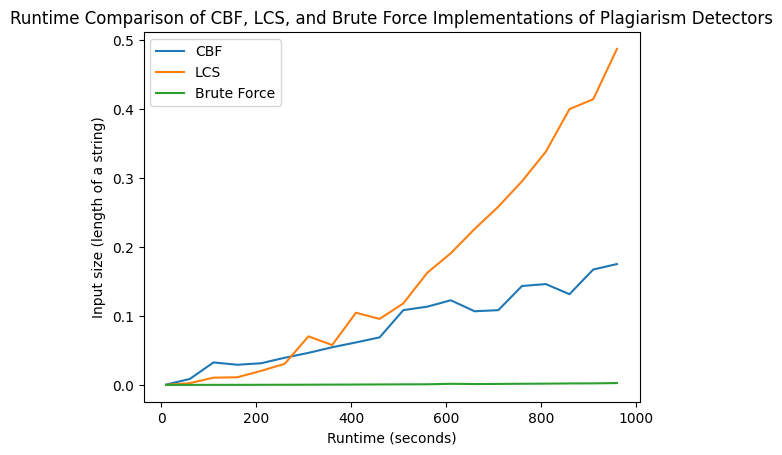

In [35]:
# Define a function to generate random text of a given length
def generate_random_text(length):
    """
    Generates a random text of given length.

    Parameters
    ----------
    length : int
        The length of the random text to be generated.

    Returns
    -------
    text : list
        A list of random letters generated from 'a' to 'j'.
    """
    text = []
    for i in range(length):
        text.append(random.choice(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']))
    return text

def compare_plagiarism_methods(input_sizes, num_tests):
    """
    Compare the runtime of different plagiarism detection methods.

    Parameters
    ----------
    input_sizes : list
        A list of input sizes (i.e., lengths of the texts) to compare.
    num_tests : int
        The number of times to run each method for each input size.

    Returns
    -------
    cbf_runtime_list : list
        A list of average runtimes (in seconds) of the CBF implementation for each input size.
    lcs_runtime_list : list
        A list of average runtimes (in seconds) of the LCS implementation for each input size.
    bf_runtime_list : list
        A list of average runtimes (in seconds) of the brute force implementation for each input size.
    """
    cbf_runtime_list=[]
    lcs_runtime_list=[]
    bf_runtime_list=[]

    # Run the tests for each input size
    for input_size in input_sizes:
        # Generate two random texts of the given length
        text1 = generate_random_text(input_size)
        text2 = generate_random_text(input_size)

        # Measure the runtime of the CBF implementation
        cbf_start_time = time.time()
        for i in range(num_tests):
            detector = PlagiarismDetector()
            detector.detect_plagiarism(text1, text2)
        cbf_end_time = time.time()

        # Measure the runtime of the LCS implementation
        lcs_start_time = time.time()
        for i in range(num_tests):
            detector = PlagiarismDetectorLCS(text1, text2)
            plagiarism_percentage = detector.detect()
        lcs_end_time = time.time()

        # Measure the runtime of the Brute Force implementation
        bf_start_time = time.time()
        for i in range(num_tests):
            BruteForcePlagiarismDetector(text1, text2)
        bf_end_time = time.time()

        # Calculate the average runtimes
        cbf_runtime = (cbf_end_time - cbf_start_time) / num_tests
        lcs_runtime = (lcs_end_time - lcs_start_time) / num_tests
        bf_runtime = (bf_end_time - bf_start_time) / num_tests
        
        # Store average runtimes
        cbf_runtime_list.append(cbf_runtime)
        lcs_runtime_list.append(lcs_runtime)
        bf_runtime_list.append(bf_runtime)
    
    return cbf_runtime_list,lcs_runtime_list,bf_runtime_list

# Define inout sizes and run the function
input_sizes=[i for i in range(10, 1000, 50)]
cbf_runtime_list,lcs_runtime_list,bf_runtime_list = compare_plagiarism_methods(input_sizes,50)

# Plot the results
plt.plot(input_sizes ,cbf_runtime_list,label='CBF')
plt.plot(input_sizes ,lcs_runtime_list,label='LCS')
plt.plot(input_sizes ,bf_runtime_list,label='Brute Force')
plt.legend()
plt.title('Runtime Comparison of CBF, LCS, and Brute Force Implementations of Plagiarism Detectors')
plt.ylabel('Input size (length of a string)')
plt.xlabel('Runtime (seconds)')
plt.show()